In [ ]:
from numpy import *
import qiskit.quantum_info as qi
from qiskit import *

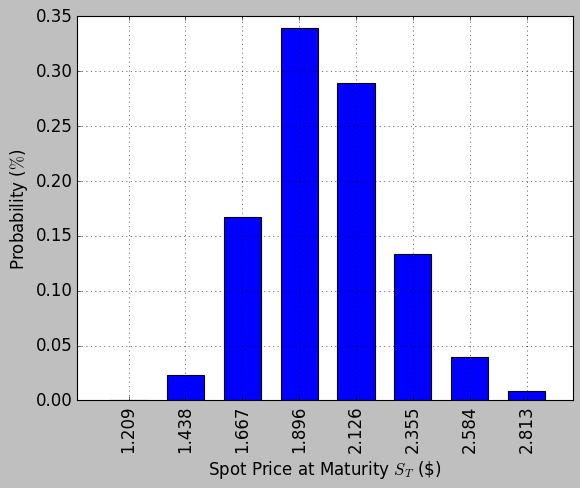

[1.20860724 1.43785917 1.66711109 1.89636302 2.12561495 2.35486687
 2.5841188  2.81337073]
1.0


In [11]:
import matplotlib.pyplot as plt
from qiskit_finance.circuit.library import LogNormalDistribution

S0 = 2  
sigma = 0.4
r = 0.05
T = 40/365
K=1.896

# resulting parameters for log-normal distribution
mu = (r - 0.5 * sigma**2) * T + log(S0)
sigmad = sigma * sqrt(T)
mean = exp(mu + sigmad**2 / 2)
variance = (exp(sigmad**2) - 1) * exp(2 * mu + sigmad**2)
stddev = sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

#low=5
#high=17


Distr = LogNormalDistribution(
    3, mu=mu, sigma=sigmad**2, bounds=(low, high)
)

x = Distr.values
y = Distr.probabilities
plt.style.use('classic')
plt.bar(x, y, width=0.15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()
print(Distr.values)
print(sum(Distr.probabilities))


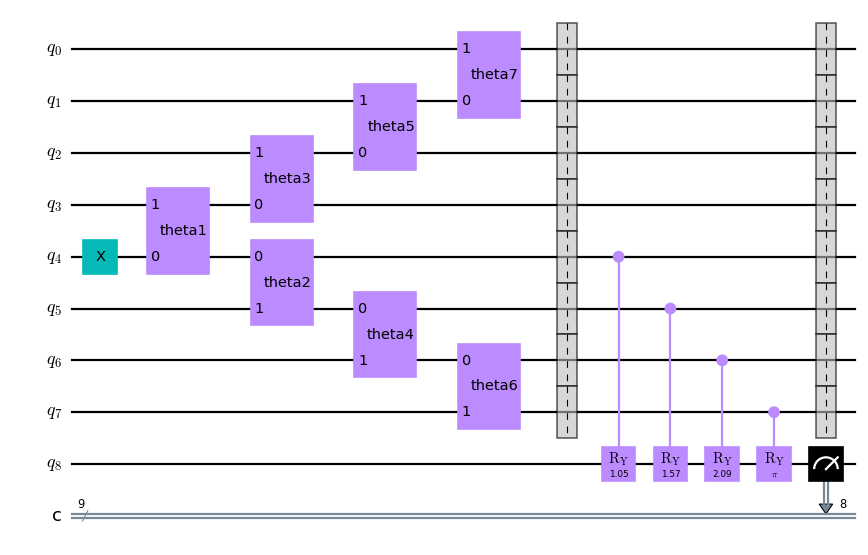

In [12]:


a0=sqrt(Distr.probabilities[0])
a1=sqrt(Distr.probabilities[1])
a2=sqrt(Distr.probabilities[2])
a3=sqrt(Distr.probabilities[3])
a4=sqrt(Distr.probabilities[4])
a5=sqrt(Distr.probabilities[5])
a6=sqrt(Distr.probabilities[6])
a7=sqrt(Distr.probabilities[7])

theta7=arctan(a0/a1);
theta6=arctan(a7/a6);
theta5=arctan(a1/(a2*cos(theta7)));
theta4=arctan(a6/(a5*cos(theta6)));
theta3=arctan(a2/(a3*cos(theta5)));
theta2=arctan(a5/(a4*cos(theta4)));
theta1=arctan((a3*cos(theta2))/(a4*cos(theta3)));


p_swap1=qi.Operator([[1, 0, 0, 0],
                  [0, cos(theta1), sin(theta1), 0],
                  [0, -sin(theta1), cos(theta1), 0],
                  [0, 0, 0, 1]])

p_swap2=qi.Operator([[1, 0, 0, 0],
                  [0, cos(theta2), sin(theta2), 0],
                  [0, -sin(theta2), cos(theta2), 0],
                  [0, 0, 0, 1]])

p_swap3=qi.Operator([[1, 0, 0, 0],
                  [0, cos(theta3), sin(theta3), 0],
                  [0, -sin(theta3), cos(theta3), 0],
                  [0, 0, 0, 1]])
p_swap4=qi.Operator([[1, 0, 0, 0],
                  [0, cos(theta4), sin(theta4), 0],
                  [0, -sin(theta4), cos(theta4), 0],
                  [0, 0, 0, 1]])

p_swap5=qi.Operator([[1, 0, 0, 0],
                  [0, cos(theta5), sin(theta5), 0],
                  [0, -sin(theta5), cos(theta5), 0],
                  [0, 0, 0, 1]])

p_swap6=qi.Operator([[1, 0, 0, 0],
                  [0, cos(theta6), sin(theta6), 0],
                  [0, -sin(theta6), cos(theta6), 0],
                  [0, 0, 0, 1]])

p_swap7=qi.Operator([[1, 0, 0, 0],
                  [0, cos(theta7), sin(theta7), 0],
                  [0, -sin(theta7), cos(theta7), 0],
                  [0, 0, 0, 1]])


circ = QuantumCircuit(9)



meas = QuantumCircuit(9,9)
meas.x(4)

meas.unitary(p_swap1, [4,3],label='theta1')
meas.unitary(p_swap2, [4,5],label='theta2')
meas.unitary(p_swap3, [3,2],label='theta3')
meas.unitary(p_swap4, [5,6],label='theta4')
meas.unitary(p_swap5, [2,1],label='theta5')
meas.unitary(p_swap6, [6,7],label='theta6')
meas.unitary(p_swap7, [1,0],label='theta7')



meas.barrier(range(8))
#meas.cry(2*arcsin(sqrt((Distr.values[0]-K)/(high-K))),0,8)
#meas.cry(2*arcsin(sqrt((Distr.values[1]-K)/(high-K))),1,9)
#meas.cry(2*arcsin(sqrt((Distr.values[2]-K)/(high-K))),2,9)
#meas.cry(2*arcsin(sqrt((Distr.values[3]-K)/(high-K))),3,9)
meas.cry(2*arcsin(sqrt((Distr.values[4]-K)/(high-K))),4,8)
meas.cry(2*arcsin(sqrt((Distr.values[5]-K)/(high-K))),5,8)
meas.cry(2*arcsin(sqrt((Distr.values[6]-K)/(high-K))),6,8)
meas.cry(2*arcsin(sqrt((Distr.values[7]-K)/(high-K))),7,8)


meas.barrier(range(8))
circ.add_register(meas.cregs[0])



#from qiskit import Aer
#backend = Aer.get_backend('statevector_simulator') 
#job = backend.run(meas)
#result = job.result()
#outputstate = result.get_statevector(meas, decimals=3)
#print(outputstate)

#from qiskit.visualization import plot_state_city
#plot_state_city(outputstate)


meas.measure(8,8)

qc = circ.compose(meas)

qc.draw()
#plot_state_city(outputstate)

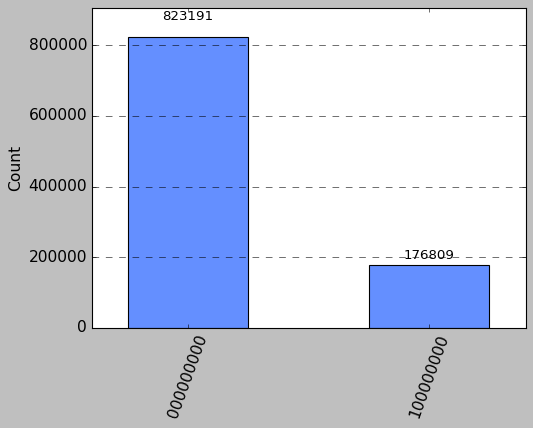

In [13]:

backend_sim = Aer.get_backend('qasm_simulator')

nshots=1e6
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=nshots)


result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

from qiskit.visualization import plot_histogram


#print(0.09837*(high-K)+(1-(high-K)))
#print(counts.int_raw[256]*(high-K)/nshots)
plot_histogram(counts)



In [14]:
#val=[0,(counts.int_raw[2]/nshots),
#(counts.int_raw[4]/nshots),
#(counts.int_raw[8]/nshots),
#(counts.int_raw[16]/nshots),
#(counts.int_raw[32]/nshots),
#(counts.int_raw[64]/nshots),
#(counts.int_raw[128]/nshots)]


payoff = maximum(0, Distr.values - K)
#V=dot(Distr.values[3:7]-K,val[3:7])
ex=dot(payoff,Distr.probabilities)
print(Distr.values[3:7])
print(Distr.probabilities[3:7])
#print(V)
print(ex)


[1.89636302 2.12561495 2.35486687 2.5841188 ]
[0.33977531 0.28936531 0.13310021 0.0392238 ]
0.16227609350087316


In [15]:
payoff = maximum(0, Distr.values - K)
ex=dot(payoff,Distr.probabilities)
print(ex)
print(counts.int_raw[256]*(high-K)/nshots)

0.16227609350087316
0.16219940106391828


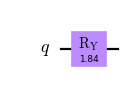

In [17]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self):
        super().__init__(1)  # circuit on 1 qubit
        #theta_p = 2 * np.arcsin(np.sqrt(0.7))
        theta_p = 2*a4*arcsin(sqrt((Distr.values[4]-K)/(high-K)))+2*a5*arcsin(sqrt((Distr.values[5]-K)/(high-K)))+2*a6*arcsin(sqrt((Distr.values[6]-K)/(high-K)))+2*a7*arcsin(sqrt((Distr.values[7]-K)/(high-K)))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self):
        super().__init__(1)  # circuit on 1 qubit
        #self._theta_p = 2 * np.arcsin(np.sqrt(0.7))
        self._theta_p = 2*a4*arcsin(sqrt((Distr.values[4]-K)/(high-K)))+2*a5*arcsin(sqrt((Distr.values[5]-K)/(high-K)))+2*a6*arcsin(sqrt((Distr.values[6]-K)/(high-K)))+2*a7*arcsin(sqrt((Distr.values[7]-K)/(high-K)))

        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k
    
    
A = BernoulliA()

Q = BernoulliQ()    
    
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)
A.draw()

In [18]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)



In [19]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    quantum_instance=quantum_instance,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.6322675171476413
